# 세그멘테이션 모델 만들기 - 프로젝트 : 개선된 U-Net 모델 만들기

개선된 U-Net++로 바꿔봅시다. U-Net의 모델 코드를 조금만 수정하면 충분히 구현할 수 있습니다.

In [1]:
#필요한 라이브러리 호출
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print("슝=3")

슝=3


In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train = True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height = (300, 370),
                w2h_ratio = 370/1242,
                height = 224,
                width = 224,
                p = 0.5
            ),
            Resize(
                width = 224,
                height = 224
            )
        ])
        
    else:
        return Compose([
            Resize(
                width = 224,
                height = 224
            )
        ])

## Step 1. KITTI 데이터셋 수집과 구축

다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.



In [5]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

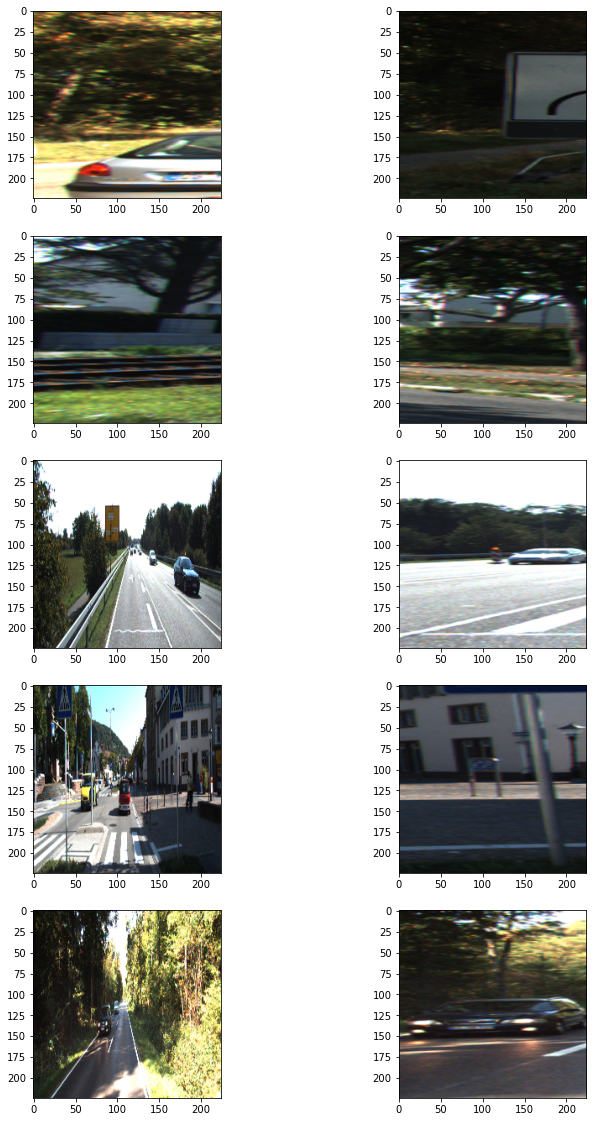

In [6]:
# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### 데이터셋 구성하기

In [14]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 dir_path,
                 batch_size = 4,
                 img_size = (224, 224, 3),
                 output_size = (224, 224),
                 is_train = True,
                 augmentation = None
                ):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset*()을 통해 kitti dataset의 directory path에서 라벨과 이미지를 확인
        self.data = self.load_dataset()
        
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", '*.png'))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length. dataset을 batch_size로 나누거 소숫점 첫째자리에서 올림!
        return math.ceil(len(self.data)/ self.batch_size)
    
    def __getitem__(self, index):
        # 입력과 출력을 만듦
        # 입력은 resize 및 augmentation이 적용된 Input_image
        # 출력은 sementic label
        batch_data = self.data[index * self.batch_size:(index+1)*self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                'image' : _input,
                'mask' : _output
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented['image']/255
            outputs[i] = augmented['mask']
        
        return inputs, outputs
    
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수.
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
        return self.indexes
        
    

In [15]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net이 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.



### 기본 U-Net 만들기

In [24]:
def build_unet(input_shape = (224, 224, 4)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [26]:
unet = build_unet()
unet.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')
unet.fit_generator(
    generator = train_generator,
    validation_data = test_generator,
    steps_per_epoch = len(train_generator),
    epochs = 50
)

unet_path = dir_path + '/seg_model_unet.h5'
unet.same(unet_path)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50


InvalidArgumentError:  input depth must be evenly divisible by filter depth: 3 vs 4
	 [[node functional_3/conv2d_52/Relu (defined at <ipython-input-26-d60ffd8d45d3>:7) ]] [Op:__inference_train_function_4400]

Function call stack:
train_function


## Step 3. U-Net과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.